#### 폰트 설정 및 라이브러리 설치 

In [1]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r"D:\nanum-all\나눔 글꼴\나눔바른고딕\NanumFontSetup_TTF_BARUNGOTHIC\NanumBarunGothic.ttf", # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

zsh:1: command not found: apt-get


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# 서울시 상권분석 서비스에서 전처리 한 최종 데이터 파일 last.csv 파일 불러오기
# 군집화 완료한 cluster1부터 cluster5까지 불러오기

In [3]:
data = pd.read_csv('last.csv')
data.drop(columns='점포수', inplace=True)

cluster1 = pd.read_csv('cluster1.csv')
cluster2 = pd.read_csv('cluster2.csv')
cluster3 = pd.read_csv('cluster3.csv')
cluster4 = pd.read_csv('cluster4.csv')
cluster5 = pd.read_csv('cluster5.csv')

# 모델링에 사용할 데이터 전처리

In [4]:
# 교통시설 수 계산
data['교통시설_수'] = data['지하철_역_수'] + data['버스_정거장_수'] + data['공항_수'] + data['철도_역_수'] + data['버스_터미널_수']

# 학교 수 계산
data['학교_수'] = data['유치원_수'] + data['초등학교_수'] + data['중학교_수'] + data['고등학교_수'] + data['대학교_수']

# 기타 집객시설 수 계산
data['기타_집객시설_수'] = data['집객시설_수'] - data['지하철_역_수'] - data['버스_정거장_수'] - data['공항_수'] - data['철도_역_수'] - data['버스_터미널_수'] - data['초등학교_수'] - data['중학교_수'] - data['고등학교_수'] - data['대학교_수']

# 필요한 열 삭제
drop_columns = [
    '지하철_역_수', '버스_정거장_수', '공항_수', '철도_역_수', '버스_터미널_수', '집객시설_수',
    '관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수', '초등학교_수',
    '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수'
]

# 삭제할 열 제거
data = data.drop(columns=drop_columns)


In [5]:
# '상주인구'가 열 이름에 포함된 열들을 모아 리스트로 저장
resident_columns = [col for col in data.columns if '상주인구' in col]

# '생활인구'가 열 이름에 포함된 열들을 모아 리스트로 저장
living_columns = [col for col in data.columns if '생활인구' in col]

# '직장_인구'가 열 이름에 포함된 열들을 모아 리스트로 저장
work_columns = [col for col in data.columns if '직장_인구' in col]


In [6]:
# '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수', '총_생활인구_수',
# '남성_생활인구_수', '여성_생활인구_수', '총_상주인구_수', '남성_상주인구_수', '여성_상주인구_수' 열을 삭제
data.drop(columns=['총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수',
                   '총_생활인구_수', '남성_생활인구_수', '여성_생활인구_수',
                   '총_상주인구_수', '남성_상주인구_수', '여성_상주인구_수'], inplace=True)


In [7]:
# 비경제활동가능인구와 경제활동가능인구를 구분하는 열 이름을 리스트로 저장
non_economic_resident_columns = ['연령대_10_상주인구_수', '연령대_60_이상_상주인구_수']
economic_resident_columns = [
    '연령대_20_상주인구_수', '연령대_30_상주인구_수', '연령대_40_상주인구_수', '연령대_50_상주인구_수'
]

non_economic_living_columns = ['연령대_10_생활인구_수', '연령대_60_이상_생활인구_수']
economic_living_columns = [
    '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수'
]

non_economic_work_columns = ['연령대_10_직장_인구_수', '연령대_60_이상_직장_인구_수']
economic_work_columns = [
    '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수'
]

# 필요한 열 삭제
data = data.drop(
    non_economic_resident_columns + economic_resident_columns +
    non_economic_living_columns + economic_living_columns +
    non_economic_work_columns + economic_work_columns, axis=1
)

# '_amount' 또는 '_prob'가 열 이름에 포함된 열을 모아 리스트로 저장
columns_to_drop = [
    col for col in data.columns if '_amount' in col or '_prob' in col
]

# 리스트에 포함된 열들을 데이터프레임에서 삭제
data = data.drop(columns=columns_to_drop)

# 결과 확인
data.head()

,상권_코드,월_평균_소득_금액,소득_구간_코드,운영_영업_개월_평균,폐업_영업_개월_평균,서울_운영_영업_개월_평균,서울_폐업_영업_개월_평균,남성연령대_10_상주인구_수,남성연령대_20_상주인구_수,남성연령대_30_상주인구_수,...,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,교통시설_수,학교_수,기타_집객시설_수
0,2110001,4.453866e+06,8.0625,98.5000,61.4375,110.1875,53.5625,105.0000,81.1250,51.125,...,2458.852699,109.510440,911.907102,1150.841903,1733.157315,2038.034517,1403.714062,4.5625,0.0000,4.6875
1,2110002,3.363814e+06,7.0000,131.3750,60.9375,110.1875,53.5625,41.8125,25.1250,29.125,...,13575.698055,887.768065,6381.697933,5654.243959,6618.587135,6446.506474,5148.741909,4.0000,0.0000,14.6875
2,2110003,3.540374e+06,7.0000,115.5625,57.8750,110.1875,53.5625,279.0625,244.8750,185.125,...,2483.022330,281.721923,1355.550478,936.750965,1269.679864,1240.204039,831.389037,6.2500,0.0000,9.4375
3,2110004,2.658326e+06,6.0000,155.1250,77.8125,110.1875,53.5625,32.7500,31.1250,27.750,...,1201.051098,47.036149,265.494807,318.650785,587.035335,721.010926,716.296848,2.0000,0.0000,3.9375
4,2110005,3.696801e+06,7.1875,117.2500,58.1875,110.1875,53.5625,160.3125,119.5625,98.375,...,2739.711102,143.256112,1304.587301,1131.586194,1590.647099,1207.356451,676.489609,5.3125,0.6875,12.4375


In [8]:
# 각 클러스터에 해당하는 상권 코드를 'cluster' 열에 지정
data.loc[data['상권_코드'].isin(cluster1['상권_코드']), 'cluster'] = 'cluster1'
data.loc[data['상권_코드'].isin(cluster2['상권_코드']), 'cluster'] = 'cluster2'
data.loc[data['상권_코드'].isin(cluster3['상권_코드']), 'cluster'] = 'cluster3'
data.loc[data['상권_코드'].isin(cluster4['상권_코드']), 'cluster'] = 'cluster4'
data.loc[data['상권_코드'].isin(cluster5['상권_코드']), 'cluster'] = 'cluster5'

# 'cluster' 열은 각 상권이 어떤 클러스터에 속하는지를 나타냄
data['cluster']


0       cluster3
1       cluster1
2       cluster5
3       cluster3
4       cluster5
          ...   
1055    cluster5
1056    cluster4
1057    cluster1
1058    cluster1
1059    cluster1
Name: cluster, Length: 1060, dtype: object

In [9]:
# 분기당_매출_금액이 1e+09 이상인 상권_코드 제외하고 학습
data = data[data['상권_코드'] != 2110065]
data = data[data['상권_코드'] != 2110164]
data = data[data['상권_코드'] != 2110116]
data = data[data['상권_코드'] != 2110788]
data = data[data['상권_코드'] != 2110131]
data = data[data['상권_코드'] != 2110137]

In [10]:
# 'cluster' 열을 데이터프레임에서 삭제
data.drop(columns='cluster', inplace=True)


In [11]:
# 각 클러스터에 해당하는 상권 코드를 기준으로 데이터를 분할
data1 = data[data['상권_코드'].isin(cluster1['상권_코드'])]
data2 = data[data['상권_코드'].isin(cluster2['상권_코드'])]
data3 = data[data['상권_코드'].isin(cluster3['상권_코드'])]
data4 = data[data['상권_코드'].isin(cluster4['상권_코드'])]
data5 = data[data['상권_코드'].isin(cluster5['상권_코드'])]

# 각 데이터에서 '상권_코드' 열을 삭제
data1.drop(columns=['상권_코드'], inplace=True)
data2.drop(columns=['상권_코드'], inplace=True)
data3.drop(columns=['상권_코드'], inplace=True)
data4.drop(columns=['상권_코드'], inplace=True)
data5.drop(columns=['상권_코드'], inplace=True)

/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_27191/2975856361.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.drop(columns=['상권_코드'], inplace=True)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_27191/2975856361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(columns=['상권_코드'], inplace=True)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_27191/2975856361.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [12]:
import numpy as np

# 데이터프레임 리스트 생성
dataframes = [data1, data2, data3, data4, data5]

percentiles = [0.33, 0.66]
#percentiles = [0.2, 0.4, 0.6, 0.8]
#percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

results = []

# 각 percentile 별로 처리
for percentile in percentiles:
    percentile_values = []
    
    # 각 데이터프레임 별로 처리
    for df in dataframes:
        percentile_value = df['주말_매출_금액'].quantile(percentile)
        percentile_values.append(percentile_value)
    
    # 해당 percentile에서의 평균 계산
    avg_value = np.mean(percentile_values)
    results.append(avg_value)

# 결과 출력
for idx, percentile in enumerate(percentiles):
    print(f"{percentile:.1f} percentile 평균 값: {results[idx]}")

results = [0] + results + [float('inf')]

# 각 데이터프레임 별로 처리
for df in dataframes:
    df['주말_매출_범주'] = pd.cut(df['주말_매출_금액'], bins=results, labels=range(0,3), right=False)

# 결과 출력 (data1을 예시로 출력)
print(data1[ '주말_매출_범주'].unique().sort_values())
print(data2[ '주말_매출_범주'].unique().sort_values())
print(data3[ '주말_매출_범주'].unique().sort_values())
print(data4[ '주말_매출_범주'].unique().sort_values())
print(data5[ '주말_매출_범주'].unique().sort_values())

/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_27191/3778365014.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['주말_매출_범주'] = pd.cut(df['주말_매출_금액'], bins=results, labels=range(0,3), right=False)


0.3 percentile 평균 값: 33067837.6329663
0.7 percentile 평균 값: 56059909.93446863
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]


/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_27191/3778365014.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['주말_매출_범주'] = pd.cut(df['주말_매출_금액'], bins=results, labels=range(0,3), right=False)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_27191/3778365014.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['주말_매출_범주'] = pd.cut(df['주말_매출_금액'], bins=results, labels=range(0,3), right=False)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_27191/3778365014.py:33:

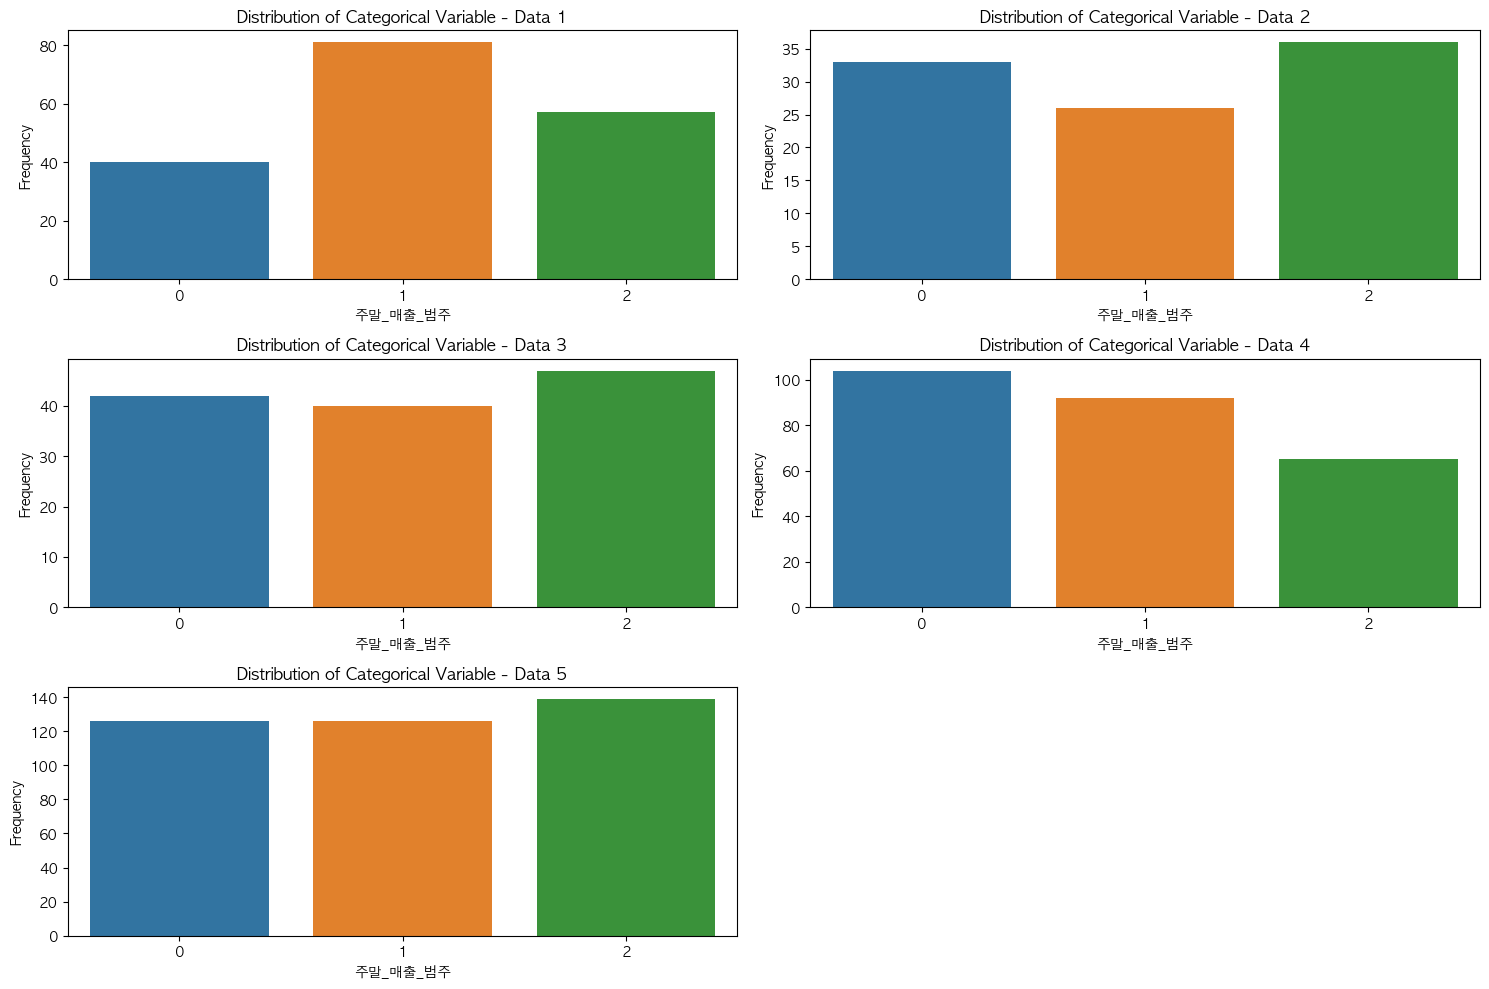

In [13]:
# 데이터 프레임 리스트 생성
dataframes = [data1, data2, data3, data4, data5]
num_rows = 3
num_cols = 2

# 그래프 그리기
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for idx, df in enumerate(dataframes):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    
    category_counts = df['주말_매출_범주'].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Distribution of Categorical Variable - Data {idx+1}")
    ax.set_xlabel("주말_매출_범주")
    ax.set_ylabel("Frequency")

# 빈 서브플롯 제거
for idx in range(len(dataframes), num_rows*num_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


# Cluster1 로지스틱

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Multiclass Logistic Regression Model:
Accuracy: 0.6667
F1-Score (Macro): 0.6815
F1-Score (Weighted): 0.6596
남성연령대_10_상주인구_수: 0.0472
남성연령대_20_상주인구_수: -0.0804
남성연령대_30_상주인구_수: -0.0051
남성연령대_40_상주인구_수: 0.0596

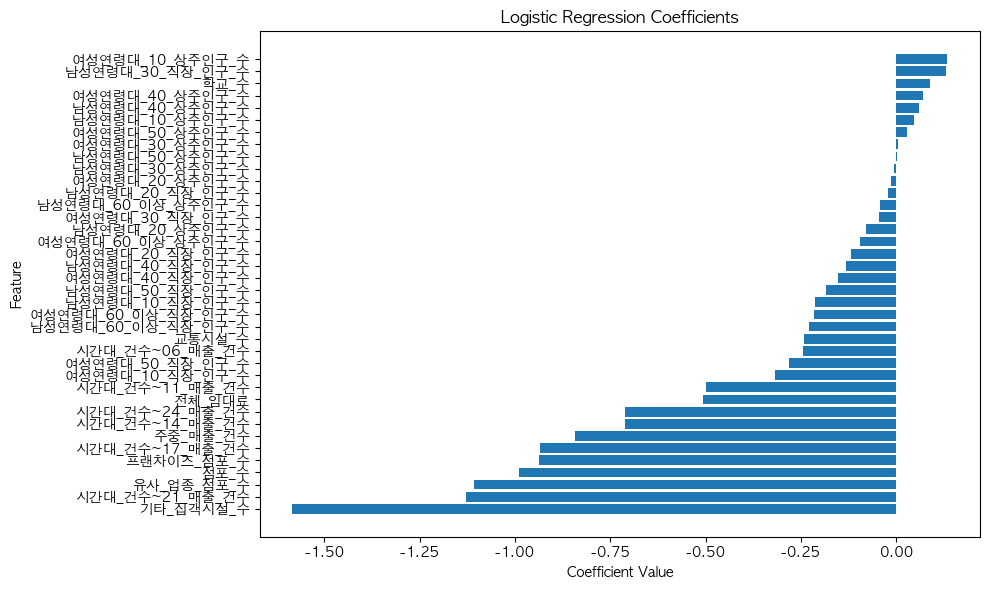

In [14]:
# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report


# 다중분류 로지스틱 회귀 모델 생성
logreg_model = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42)

# 모델 학습
logreg_model.fit(x_train, y_train)

# 예측
y_pred = logreg_model.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Multiclass Logistic Regression Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# 모델의 계수 확인
coefficients = logreg_model.coef_

# 변수별 계수 값 출력
for feature_name, coef in zip(x_train.columns, coefficients[0]):
    print(f"{feature_name}: {coef:.4f}")

    import matplotlib.pyplot as plt
import numpy as np

# 모델의 계수 확인
coefficients = logreg_model.coef_[0]
feature_names = x_train.columns

# 계수 값으로 정렬된 인덱스
sorted_idx = np.argsort(coefficients)

# 막대 그래프를 위한 변수명 설정
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_coefficients = [coefficients[i] for i in sorted_idx]

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()


# Cluster2 로지스틱

In [15]:
data1 = data2

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Multiclass Logistic Regression Model:
Accuracy: 0.5263
F1-Score (Macro): 0.4444
F1-Score (Weighted): 0.4211
남성연령대_10_상주인구_수: 0.1172
남성연령대_20_상주인구_수: 0.3007
남성연령대_30_상주인구_수: 0.3001
남성연령대_40_상주인구_수: 0.1113
남

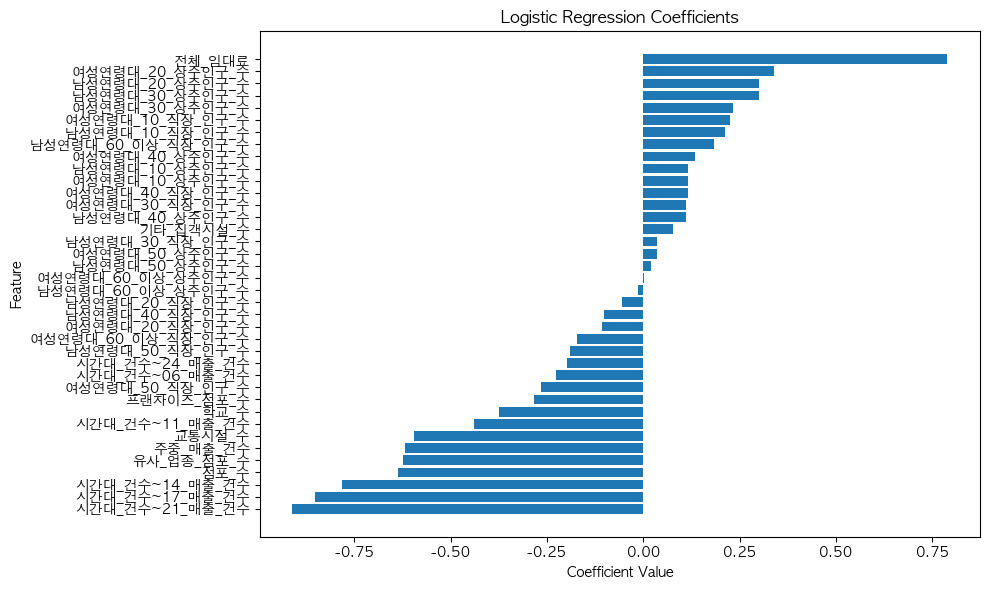

In [16]:
# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report


# 다중분류 로지스틱 회귀 모델 생성
logreg_model = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42)

# 모델 학습
logreg_model.fit(x_train, y_train)

# 예측
y_pred = logreg_model.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Multiclass Logistic Regression Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# 모델의 계수 확인
coefficients = logreg_model.coef_

# 변수별 계수 값 출력
for feature_name, coef in zip(x_train.columns, coefficients[0]):
    print(f"{feature_name}: {coef:.4f}")

    import matplotlib.pyplot as plt
import numpy as np

# 모델의 계수 확인
coefficients = logreg_model.coef_[0]
feature_names = x_train.columns

# 계수 값으로 정렬된 인덱스
sorted_idx = np.argsort(coefficients)

# 막대 그래프를 위한 변수명 설정
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_coefficients = [coefficients[i] for i in sorted_idx]

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()


# Cluster3 로지스틱

In [17]:
data1 = data3

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Multiclass Logistic Regression Model:
Accuracy: 0.5000
F1-Score (Macro): 0.5046
F1-Score (Weighted): 0.5144
남성연령대_10_상주인구_수: -0.0919
남성연령대_20_상주인구_수: 0.0592
남성연령대_30_상주인구_수: 0.0312
남성연령대_40_상주인구_수: -0.1265

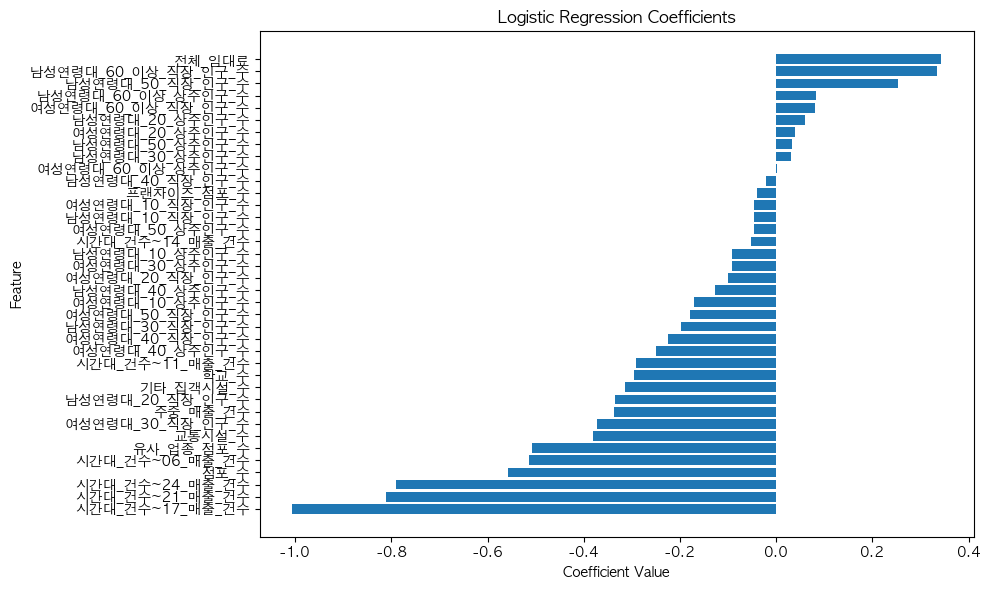

In [18]:
# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report


# 다중분류 로지스틱 회귀 모델 생성
logreg_model = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42)

# 모델 학습
logreg_model.fit(x_train, y_train)

# 예측
y_pred = logreg_model.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Multiclass Logistic Regression Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# 모델의 계수 확인
coefficients = logreg_model.coef_

# 변수별 계수 값 출력
for feature_name, coef in zip(x_train.columns, coefficients[0]):
    print(f"{feature_name}: {coef:.4f}")

    import matplotlib.pyplot as plt
import numpy as np

# 모델의 계수 확인
coefficients = logreg_model.coef_[0]
feature_names = x_train.columns

# 계수 값으로 정렬된 인덱스
sorted_idx = np.argsort(coefficients)

# 막대 그래프를 위한 변수명 설정
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_coefficients = [coefficients[i] for i in sorted_idx]

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()


# Cluster4 로지스틱

In [19]:
data1 = data4

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Multiclass Logistic Regression Model:
Accuracy: 0.7925
F1-Score (Macro): 0.7780
F1-Score (Weighted): 0.7876
남성연령대_10_상주인구_수: 0.0674
남성연령대_20_상주인구_수: 0.1938
남성연령대_30_상주인구_수: -0.1686
남성연령대_40_상주인구_수: -0.0220

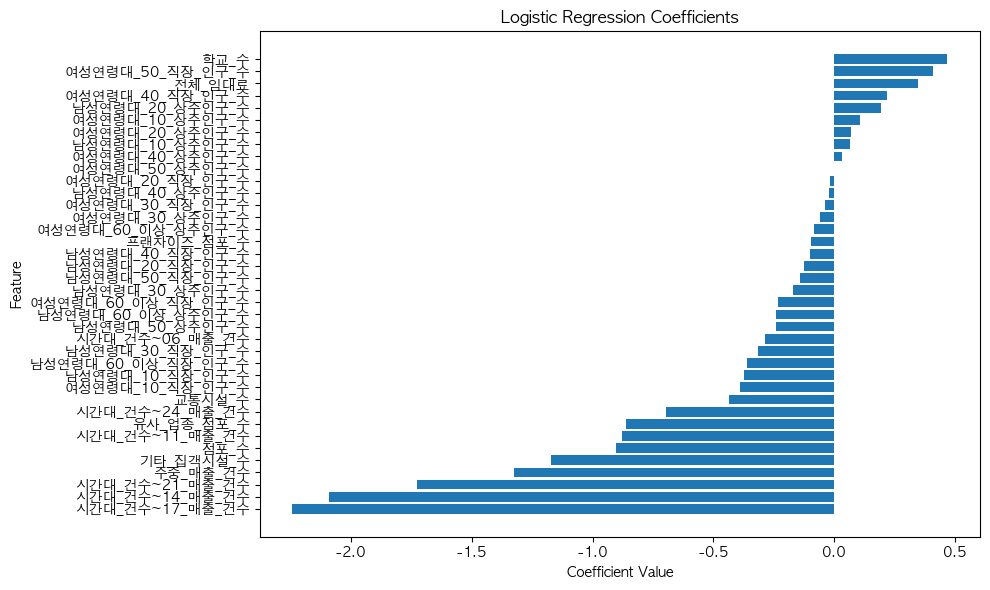

In [20]:
# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report


# 다중분류 로지스틱 회귀 모델 생성
logreg_model = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42)

# 모델 학습
logreg_model.fit(x_train, y_train)

# 예측
y_pred = logreg_model.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Multiclass Logistic Regression Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# 모델의 계수 확인
coefficients = logreg_model.coef_

# 변수별 계수 값 출력
for feature_name, coef in zip(x_train.columns, coefficients[0]):
    print(f"{feature_name}: {coef:.4f}")

    import matplotlib.pyplot as plt
import numpy as np

# 모델의 계수 확인
coefficients = logreg_model.coef_[0]
feature_names = x_train.columns

# 계수 값으로 정렬된 인덱스
sorted_idx = np.argsort(coefficients)

# 막대 그래프를 위한 변수명 설정
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_coefficients = [coefficients[i] for i in sorted_idx]

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()


# Cluster5 로지스틱

In [21]:
data1 = data5

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Multiclass Logistic Regression Model:
Accuracy: 0.6709
F1-Score (Macro): 0.6560
F1-Score (Weighted): 0.6622
남성연령대_10_상주인구_수: 0.0074
남성연령대_20_상주인구_수: 0.1792
남성연령대_30_상주인구_수: 0.0046
남성연령대_40_상주인구_수: -0.0446


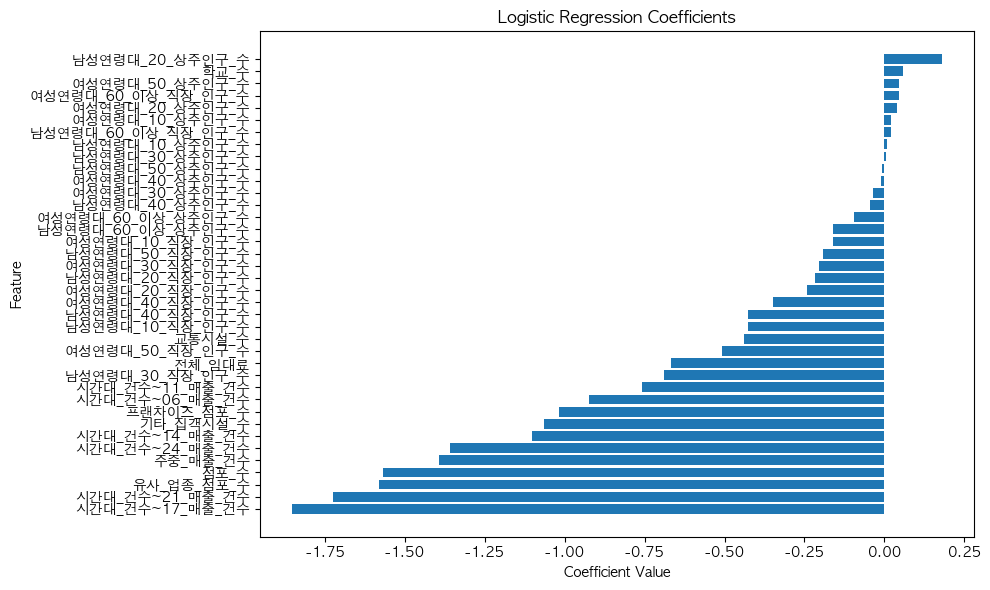

In [22]:
# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report


# 다중분류 로지스틱 회귀 모델 생성
logreg_model = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42)

# 모델 학습
logreg_model.fit(x_train, y_train)

# 예측
y_pred = logreg_model.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Multiclass Logistic Regression Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# 모델의 계수 확인
coefficients = logreg_model.coef_

# 변수별 계수 값 출력
for feature_name, coef in zip(x_train.columns, coefficients[0]):
    print(f"{feature_name}: {coef:.4f}")

    import matplotlib.pyplot as plt
import numpy as np

# 모델의 계수 확인
coefficients = logreg_model.coef_[0]
feature_names = x_train.columns

# 계수 값으로 정렬된 인덱스
sorted_idx = np.argsort(coefficients)

# 막대 그래프를 위한 변수명 설정
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_coefficients = [coefficients[i] for i in sorted_idx]

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()
